In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt
import pprint

import matplotlib as mpl
from PIL import Image
from io import BytesIO
mpl.rc('figure', dpi=400, figsize=(12,8))


%matplotlib inline

In [2]:
def TIFF_exporter(fig, fname, fig_dir = '.'):
    """
    Parameters
    ----------
    fig: matplotlib figure
    """
    
    # save figure
    # (1) save the image in memory in PNG format
    png1 = BytesIO()
    fig.savefig(png1, format='png', bbox_inches='tight', dpi=350)

    # (2) load this image into PIL
    png2 = Image.open(png1)

    # (3) save as TIFF
    png2.save(os.path.join(fig_dir,'{}.tiff'.format(fname)))
    png1.close()
    return True

In [3]:
def data_import_and_clean(dataset):
    df_zero = pd.read_csv('../../../data/SA_results/gradient/{}_zero/sensitivities.txt'.format(dataset), sep='\t')
    for p in (['u', 'P_a', 'SaO2sup', 'Pa_CO2', 'temp']):    
        df_zero = df_zero.query("Parameter!='{}'".format(p))
    return df_zero

In [28]:
datasets = ['neo007', 'neo021']
df_zero_dict = {}
for dataset in datasets:
    df_zero_dict[dataset] = data_import_and_clean(dataset)

FileNotFoundError: [Errno 2] File b'../../../data/SA_results/gradient/neo021_zero/sensitivities.txt' does not exist: b'../../../data/SA_results/gradient/neo021_zero/sensitivities.txt'

In [29]:
title_dict = {"TOTAL": "all outputs", "CCO": "CCO", "HbT": "HbT", "Hbdiff": "HbD"}

def sensitivity(df, output, title_dict=None):      
    params = ["Parameter", output+"_mu_star", output+"_mu_star_conf", output+"_sigma"]
    sens = df[params]
    sens = sens.rename(columns={output+"_mu_star": "mu_star", output+"_sigma": "sigma", output+"_mu_star_conf": "mu_star_conf"})
    sens.sort_values(by="mu_star", ascending=False, inplace=True)
    sens_head = sens.head(30)
    with sns.plotting_context("talk"):
        fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6))

        ax.set(xscale="log", yscale="log")
        plt.grid(True, linestyle=':')
        ax = sns.scatterplot(x="mu_star", y="sigma", data=sens_head, ax=ax, hue="Parameter")
        ax.set_ylabel("$\sigma$")
        ax.set_xlabel("$\mu_{*}$")
        if title_dict:
            ax.set_title("Sensitivity for {}".format(title_dict[output]))

        lgd = ax.legend(loc="upper right", bbox_to_anchor=(1.55, 1))

    
    return fig, ax, lgd, sens_head

Working on Hbdiff in neo007 - zero
Working on Hbdiff in neo021 - zero


KeyError: 'neo021'

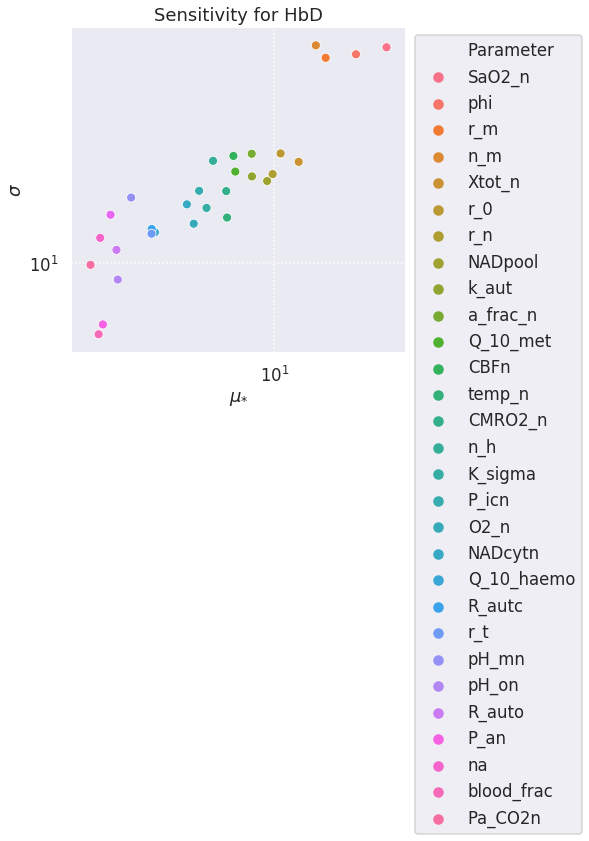

In [30]:
sim_data_zero = {}
outputs = ["Hbdiff"]
for output in outputs:
    sim_data_zero[output]={}
    for dataset in datasets:
        print("Working on {} in {} - zero". format(output, dataset))
        fig, ax, lgd, d_zero = sensitivity(df_zero_dict[dataset], output, title_dict=title_dict)
        sim_data_zero[output][dataset]= d_zero
plt.close('all')

# Combined data #


In [31]:
%%capture
l_zero = []
for output in outputs:
    for k, d in sim_data_zero[output].items():
        print("{} - {}".format(output, k))
        print(d.columns)
        d['Neonate'] = k
        d['Output'] = output
        l_zero.append(d)
                
combined_zero = pd.concat(l_zero, sort=False)


# Sensitivity Results as Scatter Plot #

Here we visualise $\mu_{*}$ again $\sigma$ for each dataset and output for the top 30 most sensitive parameters in each grouping. 
Legends for each grap hare turned off for neatness here - we're simply looking at the relationship  between $\mu_{*}$ and $\sigma$ rather than what it means for a particular variable. 

All graphs show a roughly linear relationship with the __TOTAL__ output being clustered towards higher $\mu_{*}$ values than the individual outputs.

Text(0.5, 0.98, 'NaN replaced with zero')

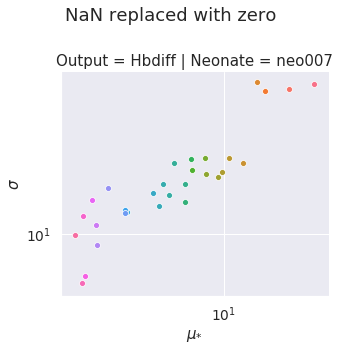

In [32]:
g = sns.FacetGrid(data=combined_zero, col='Neonate', row="Output", hue="Parameter", subplot_kws={"xscale":"log", "yscale":"log"}, height=5)
g = g.map(sns.scatterplot, "mu_star", "sigma")
g.set_xlabels("$\mu_{*}$")
g.set_ylabels("$\sigma$")

plt.subplots_adjust(top=0.8)
g.fig.suptitle('NaN replaced with zero')

# $\mu_{*}$ values as a bar chart # 

We can look at what parameters are within the top 20 for each grouping and also at their respective values. All graphs share an x axis and so can be compared directly down columns and across rows. The x-axis is on a log scale.

We see that the  __TOTAL__ output shows a small amount of drop off as the parameter becomes less sensitive than most other outputs. We also see simliar patterns for each dataset across the rows, but the actual parameters themselves do vary in each "top 10".

In order to properly visualise what parameters are within each grouping and what are most sensitive, we need to visualise the set of all parameters across all groupings.

/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


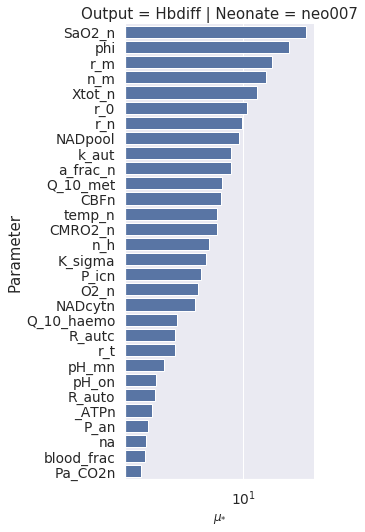

In [33]:
g = sns.FacetGrid(data=combined_zero, col='Neonate', hue='Neonate', row="Output", sharey=False, sharex=True, subplot_kws={"xscale":"log"}, height=8, aspect=0.6)
g= g.map(sns.barplot, "mu_star", "Parameter")
g.set_xlabels("$\mu_{*}$", fontsize=12)


plt.subplots_adjust(top=0.9)
g.savefig("/home/buck06191/Dropbox/phd/desat_neonate/sensitivity/neo_zero_gradient_barchart.png", transparent=True, bbox_inches = "tight", dpi=250)


In [34]:
%%capture

param_count_zero = pd.DataFrame(combined_zero.groupby(['Output', 'Parameter']).nunique()['mu_star'])

In [35]:
import itertools
tuple_index = itertools.product(outputs, datasets)

In [36]:
index = pd.MultiIndex.from_tuples(list(tuple_index), names=['Output', 'Dataset'])

In [37]:
combined_zero_indexed = combined_zero.copy().set_index(['Neonate'])

In [38]:
combined_zero_pivoted = pd.pivot_table(combined_zero.copy(), index='Parameter', columns=['Neonate'], values='mu_star')


In [39]:
combined_zero_pivoted=combined_zero_pivoted.replace(0, np.nan)

# Heat map visualisation #

In order to fully explore the parameters that have been shown as sensitive by sensitivity analysis, we can viaualise the set of all parameters in the above groupings as a heatmap. The more purple that a parameter is the more sensitive it is.

By visualising in this way we can clearly see when a parameter ispresent in multiple datasets and outputs and where it is most sensitive.

Columns are aligned such that the 4 datasets are grouped into each output, with the final output being the __TOTAL__.

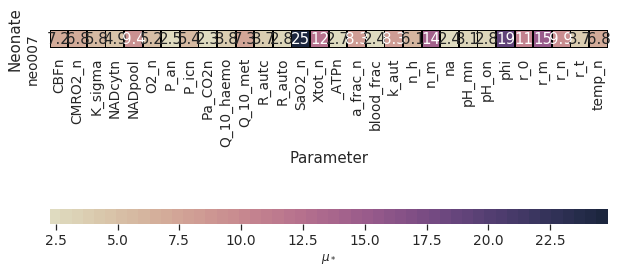

In [40]:
sns.set(font_scale=1.25)
default_ticker = mpl.ticker.MaxNLocator(10)
grid_kws = {"height_ratios": (.6, .05), "hspace": 0.75}
f, (ax, cbar_ax) = plt.subplots(nrows=2, figsize=(10,5), gridspec_kw=grid_kws)
ax = sns.heatmap(combined_zero_pivoted.T,
                 cmap = sns.cubehelix_palette(50, start=-.5, rot=.75),
                 square=True,
                 annot=True,
                 linecolor='black',
                 linewidth=1,
                 ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal", "ticks": default_ticker})

plt.subplots_adjust(top=0.9, hspace=1)
# f.suptitle('NaN replaced with zero', y=0.93, x = 0.7)
ax.collections[0].colorbar.set_label("$\mu_*$", fontsize=12)

f.savefig("/home/buck06191/Dropbox/phd/desat_neonate/sensitivity/neo_zero_gradient_heatmap.png", transparent=True, bbox_inches = "tight", dpi=250)

#sns.heatmap(combined_pivoted, cmap = sns.light_palette("green"), square=True, linecolor='black', linewidth=0.2)

In [41]:
combined_zero_indexed['Parameter'].unique()

array(['SaO2_n', 'phi', 'r_m', 'n_m', 'Xtot_n', 'r_0', 'r_n', 'NADpool',
       'k_aut', 'a_frac_n', 'Q_10_met', 'CBFn', 'temp_n', 'CMRO2_n',
       'n_h', 'K_sigma', 'P_icn', 'O2_n', 'NADcytn', 'Q_10_haemo',
       'R_autc', 'r_t', 'pH_mn', 'pH_on', 'R_auto', '_ATPn', 'P_an', 'na',
       'blood_frac', 'Pa_CO2n'], dtype=object)

# Choice of Parameters #
We decide what parameters to use for fitting based on domain knowledge informed by the above results.
A rough guide is to choose parameters that appear in at least 50% of sensitivity results. Additionally, parameters that appear to be important for one output but not other should also be considered. For example, the metabolic submodel is only represented by the CCO output and so if using only the __TOTAL__ output important parameter may not appear. This appears to be the case for *cytox_tot_tis* which appears in all datasets for CCO output, but not for any other output.

We can use the `param_count`dataframe created earlier to look at how many times each parameter appears. We can then supplement this with parameters based on domain knowledge.

Text(0, 0.5, 'No. times parameter is present')

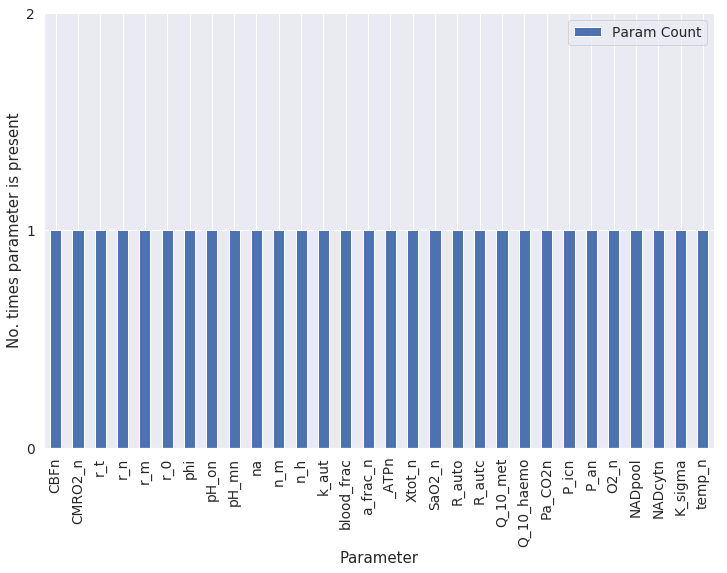

In [42]:
from matplotlib import ticker
total_count_zero = pd.DataFrame(combined_zero.groupby(['Parameter']).nunique()['mu_star'])
total_count_zero.rename({'mu_star': 'Param Count'}, axis='columns', inplace=True)
total_count_zero.sort_values(by='Param Count', ascending=False, inplace=True)

f = total_count_zero.plot.bar(figsize=(12,8))
ax = plt.gca()
ax.yaxis.set_ticks([0,1,2])
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.set_ylabel('No. times parameter is present')
#f.axhline(y=cutoff, color='r')

In [43]:


included_parameters_df_zero = total_count_zero.copy()

included_parameters_zero = list(included_parameters_df_zero.index)

In [44]:
included_parameters_zero

['CBFn',
 'CMRO2_n',
 'r_t',
 'r_n',
 'r_m',
 'r_0',
 'phi',
 'pH_on',
 'pH_mn',
 'na',
 'n_m',
 'n_h',
 'k_aut',
 'blood_frac',
 'a_frac_n',
 '_ATPn',
 'Xtot_n',
 'SaO2_n',
 'R_auto',
 'R_autc',
 'Q_10_met',
 'Q_10_haemo',
 'Pa_CO2n',
 'P_icn',
 'P_an',
 'O2_n',
 'NADpool',
 'NADcytn',
 'K_sigma',
 'temp_n']

# Final Parameter selection #


## Zero replacement ##

In [45]:
final_params_list_zero = set(included_parameters_zero)
pprint.pprint(final_params_list_zero)

{'CBFn',
 'CMRO2_n',
 'K_sigma',
 'NADcytn',
 'NADpool',
 'O2_n',
 'P_an',
 'P_icn',
 'Pa_CO2n',
 'Q_10_haemo',
 'Q_10_met',
 'R_autc',
 'R_auto',
 'SaO2_n',
 'Xtot_n',
 '_ATPn',
 'a_frac_n',
 'blood_frac',
 'k_aut',
 'n_h',
 'n_m',
 'na',
 'pH_mn',
 'pH_on',
 'phi',
 'r_0',
 'r_m',
 'r_n',
 'r_t',
 'temp_n'}


In [46]:
len(final_params_list_zero)

30

Finally, even though it wasn't identified as important by the SA process, the hypothermia model includes $Q_{10}$ as a way of controlling the impact of temperature and this parameter should be included in the fitting process for the purposes of identifying its impact as well as for fitting. Additionally, all piglets are known to have suffered hypoxic ischemic injury and therefore are likely to have suffered some degree of cell death. As a result we should also include the parameter `df` which controls cell death.

In [47]:
for p in ('Q_10_haemo', 'Q_10_met'):
    final_params_list_zero.add(p)

In [48]:
final_params_list_zero

{'CBFn',
 'CMRO2_n',
 'K_sigma',
 'NADcytn',
 'NADpool',
 'O2_n',
 'P_an',
 'P_icn',
 'Pa_CO2n',
 'Q_10_haemo',
 'Q_10_met',
 'R_autc',
 'R_auto',
 'SaO2_n',
 'Xtot_n',
 '_ATPn',
 'a_frac_n',
 'blood_frac',
 'k_aut',
 'n_h',
 'n_m',
 'na',
 'pH_mn',
 'pH_on',
 'phi',
 'r_0',
 'r_m',
 'r_n',
 'r_t',
 'temp_n'}

In [49]:
for p in ('SaO2_n', 'temp_n', 'Pa_CO2n', 'P_an', 'Vol_totn', 'Xtot_n', 'a_frac_n', 'pH_on', 'NADpool'):
    try:
        final_params_list_zero.remove(p)
    except KeyError:
        continue

As before we need to massively reduce the number of parameters.

What we can do is generate a final list that is the intersection of these two version - we should then find parameters that occur in both meaning that they are important without having a good chance of producing NAN results.

In [50]:
pprint.pprint(final_params_list_zero)

{'CBFn',
 'CMRO2_n',
 'K_sigma',
 'NADcytn',
 'O2_n',
 'P_icn',
 'Q_10_haemo',
 'Q_10_met',
 'R_autc',
 'R_auto',
 '_ATPn',
 'blood_frac',
 'k_aut',
 'n_h',
 'n_m',
 'na',
 'pH_mn',
 'phi',
 'r_0',
 'r_m',
 'r_n',
 'r_t'}


In [ ]:
print("Final parameter list length is: {}".format(len(final_params_list_zero)))

overall_selection = list(final_params_list_zero)

# Parameter config creation #

In [ ]:
def openopt_param_creator(d, f):
    """Create an input dictionary of uniform parameter priors for openopt.

    Parameters
    ----------
    d : dict
        Dictionary of paramaters and their default values.

    f : float
        Float greater than 0 to define limits of distribution. A value of 0.25
        is equivalent to a 25% change either way.

    Returns
    -------
    None
        Prints parameter specification to terminal in format compatible with
        :module:`optim.py`

    """
    for k, v in d.items():
        print('param: {}, {Dist_Type}, {Min:.4f}, {Max:.4f}, {Default:.4f}'.format(k, **v))
    return None

In [ ]:
# param_df_1 = pd.read_csv('~/repos/Github/BayesCMD/batch/scratch/pdists_hypothermia.csv',
#                        header=None,
#                        names=['Parameter', 'Dist_Type',
#                               'Min', 'Max', 'Default'],
#                         index_col=0)

param_df = pd.read_csv('/home/buck06191/repos/Github/neonatal-desat-modelling/bcmd-files/sensitivity/param_files/bp_hypothermia_params.csv',
                       header=None,
                       names=['Parameter', 'Dist_Type',
                              'Min', 'Max', 'Default'],
                        index_col=0)



In [ ]:
import json
default_values = param_df.loc[list(overall_selection)].to_dict(orient='index')
json.dumps({k: [v['Dist_Type'], [v['Min'], v['Max']]] for k,v in default_values.items()})

In [ ]:
def latex_table_param_creator(d, f):
    """Create an input dictionary of uniform parameter priors for openopt.

    Parameters
    ----------
    d : dict
        Dictionary of paramaters and their default values.

    f : float
        Float greater than 0 to define limits of distribution. A value of 0.25
        is equivalent to a 25% change either way.

    Returns
    -------
    None
        Prints parameter specification to terminal in format compatible with
        :module:`optim.py`

    """
    print(r"""\begin{table}[htbp]
\centering
\begin{tabular}{@{}l|l|l|l@{}}
\toprule
Parameter        & Min. Value & Max. Value & Default Value \\ \midrule
    """)
    for k, v in d.items():
        print('{} & {Min:.4f} & {Max:.4f} & {Default:.4f}\\\\'.format(k.replace('_', '\\_'), **v))
    print(r"""
\bottomrule
\end{tabular}
\caption{Table showing final sensitivity analysis parameters for noenatal desaturation data.}\label{tab:desat_neonate_SA}
\end{table}
    """)
    return None

In [ ]:
latex_table_param_creator(default_values, 0.5)